# Classification and regression

> **Work in progress**
>
> This section is not yet finished. Proceed with caution.

Linear regression, covered in the previous chapter, is often seen as an
entry method to enter the world of supervised machine learning. However,
not every phenomenon can be explained using a linear relationship, and
not everything is a regression. For the former, you need to use methods
that have a bit more complicated math in behind (but often the same
Python API). For the latter, you will often need to look for
classification models. Both of these options are covered in this
chapter, that will outline methods of introducing spatial dimension to
commonly used machine learning models. To a degree, it is a continuation
of the work covered last time but there are some new things here and
there.

> **This is not an introduction to ML**
>
> Note that this material does not aim to cover an introduction to
> machine learning thoroughly. There are other, much better materials
> for that. One of them can be [scikit-learn’s User
> guide](https://scikit-learn.org/stable/user_guide.html) but I am sure
> you will find one that suits you.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from sklearn import ensemble, metrics, model_selection

## Data

The data you will work with today comes from the study on the urban
development of Prague, published in @fleischmann2022Methodological. The
original dataset is significantly simplified for the purpose of this
material and contains point data reflecting the location of buildings in
Prague with a subset of measured attributes describing each one and
(aggregated) type of urban devlopment they belong to. The type is a
categorical variable that will be your dependent variable today. The
goal is to use the other variables and spatial information to predict
which type each building belongs to.

> **Caution**
>
> The dataset contains ~140k points, so I don’t recommend using
> `explore()` on all of it.

In [2]:
building_data = gpd.read_file("data/prg_building_locations.gpkg", engine="pyogrio")
building_data.head()

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/chapter_11/data/prg_building_locations.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> building_data = gpd.read_file(
>     "prg_building_locations.gpkg",
> )
> ```

The original taxonomy has been re-classified to provide eight types of
urban development shown in the figure below.

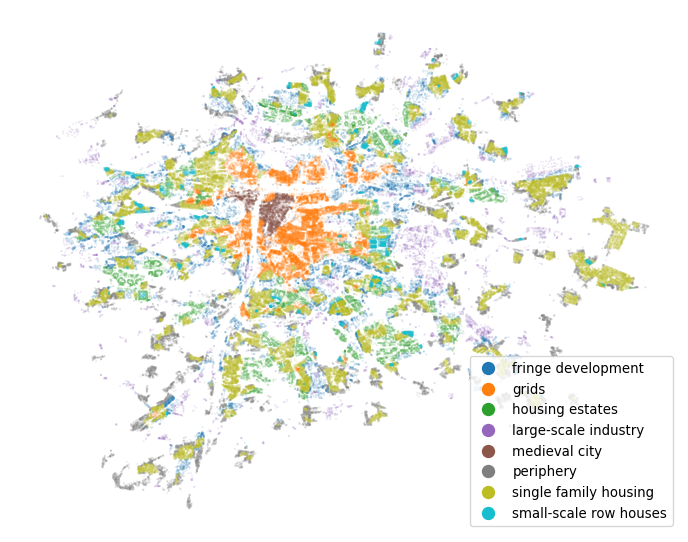

In [3]:
ax = building_data.plot(
    "cluster", legend=True, figsize=(9, 9), markersize=0.005
)
ax.set_axis_off()


List the columns containing some numerical value and save it as a
variable. There are six of them out of the original few hundred.

In [4]:
independent_variables = [
    "floor_area_ratio",
    "height",
    "compactness",
    "street_alignment",
    "interbuilding_distance",
    "block_perimeter_wall_length",
]

It may be helpful to understand the spatial distribution of each of them
to know what to expect, and build an intuition about their relationship
with the classification above.

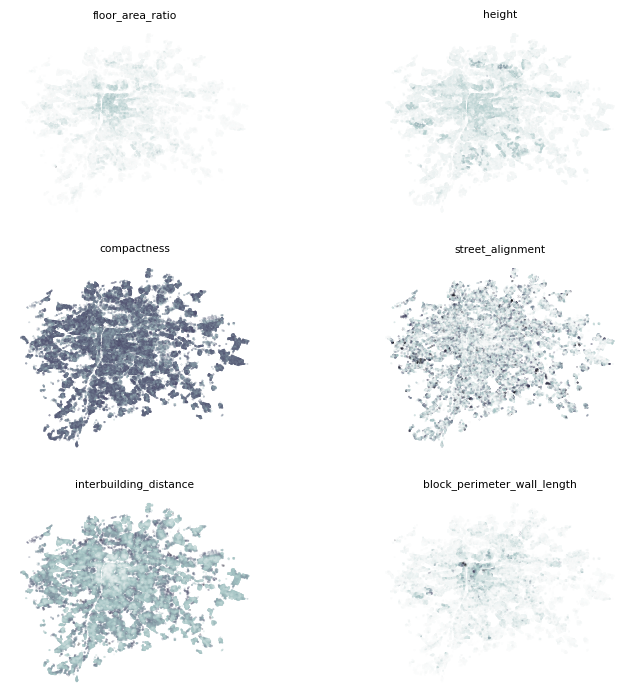

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(9, 9))
axs = axs.flatten()
for i, var in enumerate(independent_variables):
    building_data.plot(var, markersize=0.01, cmap="bone_r", ax=axs[i])
    axs[i].set_title(var, fontdict={"fontsize": 8})
    axs[i].set_axis_off()

## Classification 101

The main task of today is to train classification models using
`scikit-learn`, so let’s begin.

### Data preparation

The dataset contains a bit over 140k points. While more data tend to
bring additional performance to ML models, the relationship is far from
linear, and you often get nearly as performant models using just a
fraction of data. Moreover, it takes longer to train on more data :).

Select a random sample of 20k points you will work with. You can later
test for yourself how big of an effect the size of the sample has.

In [6]:
training_sample = building_data.sample(20_000, random_state=0)


From the sample, extract the `DataFrame` with just the independent
variables for the simplicity.

In [7]:
independent = training_sample[independent_variables]
independent.head(2)

### Train-test split

Some data are used to train the model, but the same data cannot be used
for evaluation. The models tend to learn those exact values, and the
performance metrics derived from training data show a much higher score
than the model can on unseen data. One way around this is to split the
dataset into two parts - `train` and `test`. The `train` part is used to
train the model. However, the `test` part is left out of training and is
later used to evaluate performance without worrying that any of the data
points were seen by the model before.

`scikit-learn` offers handy function to split the data into train and
test parts, dealing with both dependent and independent variables at the
same time.

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    independent, training_sample["cluster"], test_size=0.25, random_state=0
)


### Random Forest Classifier

While there is a large number of ML models available, your goal today is
not to understand which ML model is better and how to fine-tune it, but
how to include the spatial dimension in them. So let’s not complicate
the situation and stick to one of the common models - [random
forest](https://en.wikipedia.org/wiki/Random_forest).

Random forest classifier is implemented within the `ensemble` module of
`scikit-learn` and has the API you should already be familiar with. Get
the training data and fit the baseline model without thinking about
space and geography at all.

In [9]:
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

#### Prediction

The trained model can be directly used to predict the classes (type of
development in this case). Using the test portion of data, you can get
the predicted label:

In [10]:
pred = model.predict(X_test)
pred

array(['single family housing', 'single family housing', 'medieval city',
       ..., 'single family housing', 'grids', 'single family housing'],
      dtype=object)

Or probabilities for every single class. The class prediction above is
just selecting the one with the maximum probability.

In [11]:
proba = model.predict_proba(X_test)
proba

array([[0.02, 0.18, 0.06, ..., 0.04, 0.42, 0.25],
       [0.01, 0.  , 0.  , ..., 0.13, 0.86, 0.  ],
       [0.  , 0.2 , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.03, 0.09, 0.  , ..., 0.07, 0.49, 0.32],
       [0.  , 0.99, 0.  , ..., 0.  , 0.  , 0.01],
       [0.07, 0.18, 0.04, ..., 0.  , 0.52, 0.09]])

Both outputs are numpy arrays, but the probabilities would be especially
helpful to see as a `DataFrame` with column names representing class
names. Those are available as `.classes_`:

In [12]:
model.classes_

array(['fringe development', 'grids', 'housing estates',
       'large-scale industry', 'medieval city', 'periphery',
       'single family housing', 'small-scale row houses'], dtype=object)

You can quickly combine it all with the original index to get a
`DataFrame` of probabilities.

In [13]:
pd.DataFrame(proba, columns=model.classes_, index=X_test.index)

5000 rows × 8 columns

#### Evaluation

Now comes the evaluation part. Normally, you are interested in a number
of performance metrics capturing how good the model is. Among the most
common ones are *accuracy* and *Cohen’s kappa score*. Accuracy captures
the fraction of correct predictions, i.e., how many labels in the
predicted array equal the known labels. [Kappa
score](https://en.wikipedia.org/wiki/Cohen%27s_kappa) It is seen as a
more robust metric but not straightforwardly interpretable.

In [14]:
accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)


Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45


The results are not bad, considering the limited amount of information
provided in independent variables. Around 58% of labels are correctly
predicted.

Apart from the model performance, you can also evaluate how important
each of the independent variables for the result is using the
`.feature_importances_` metric. Again, wrapping it in a pandas object is
useful to get feature names alongside the values.

In [15]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

compactness                    0.125213
street_alignment               0.125471
floor_area_ratio               0.166246
height                         0.174648
block_perimeter_wall_length    0.187244
interbuilding_distance         0.221179
dtype: float64

There seems to be a relatively good balance of importance ranging from
12% for compactness to 22% for inter-building distance. Check if that
matches our intuition in relation to the spatial distribution of each of
them.

### Cross-validated prediction

Now, if you want to plot the predicted labels on a map, you can do that
reliably only for the test sample. The train sample was seen by the
model and would not be representative of model capabilities.
Nevertheless, you can create a map using the complete sample, just not
using exactly same model for all its parts. Welcome cross-validated
prediction.

Cross-validated (CV) prediction splits the dataset (prior you divided it
into train and test) into a small number of parts and trains a separate
model to predict labels for each of them. In the example below, it
creates four equally-sized parts, and then takes three of them as
*train* part to train a model that is used to predict labels on the
fourth one. Then, it switches the one that is left out and repeats the
process until there are labels for every part. The resulting labels
should not contain any data leakage between train and test samples.
However, as described below, that is not always the case when dealing
with spatial data.

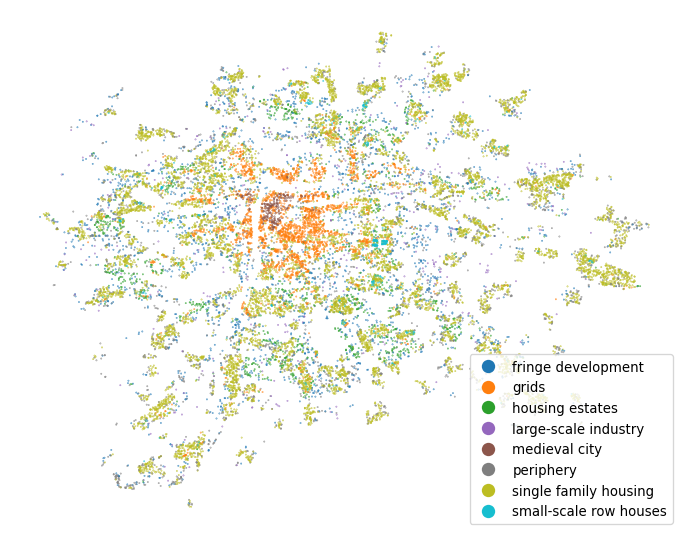

In [16]:
predicted = model_selection.cross_val_predict(
    model, independent, training_sample["cluster"], cv=4, n_jobs=-1
)

ax = training_sample.plot(predicted, legend=True, figsize=(9, 9), markersize=0.1)
ax.set_axis_off()

What CV-prediction allows to not only plot the labels, but importantly
to plot the spatial pattern of errors.

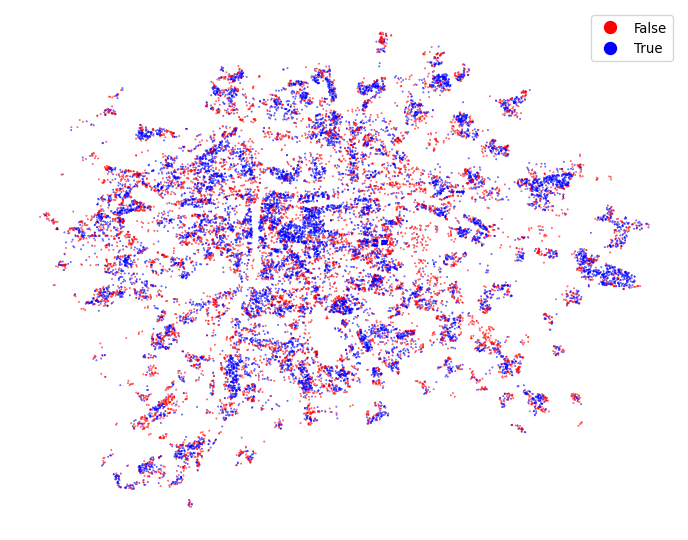

In [17]:
ax = training_sample.plot(
    predicted == training_sample["cluster"],
    categorical=True,
    figsize=(9, 9),
    markersize=0.1,
    cmap="bwr_r",
    legend=True,
)
ax.set_axis_off()

As with the linear regression, a spatial autocorrelation of errors means
that the model does not represent space reliably and may need some
adaptations.

## Spatial cross-validation

When dividing the data into *train* and *test* parts, you are trying to
eliminate data leakage, which happens when information from one set
makes its way to the other. The evaluation affected by leakage then
indicates better results than the reality is. This works well for most
of data, but not so much for spatial data. Tobler’s first law of
geography, which says that nearby things are similar, breaks the
assumption of no leakage. Two points that are right next to each other
in space, one randomly allocated to the *train* part and the other to
the *test* part, are not statistically independent. You can assume that
they will be similar, and this similarity caused by the spatial
proximity comes with a potential data leakage.

Spatial CV mitigates the issue by including a spatial dimension in the
train-test split. The aim is to divide the whole study area into smaller
regions and allocate whole regions to train and test splits. You can do
that based on many criteria but it is handy to have a variable
representing those regions, as `"basic_settlement_unit"` column in your
DataFrame.

With a categorical column indicating groups, you can use the
`StratifiedGroupKFold` class from `scikit-learn` to create the folds.

In [18]:
gkf = model_selection.StratifiedGroupKFold(n_splits=5)
splits = gkf.split(
    training_sample,
    training_sample.cluster,
    groups=training_sample.basic_settlement_unit,
)


The `splits` variable now contains an iterator - an object we can loop
through that gives you train and test parts for each split. You can
easily extract the labels indicating the splits:

In [19]:
split_label = np.empty(len(training_sample), dtype=float)
for i, (train, test) in enumerate(splits):
    split_label[test] = i
training_sample["split"] = split_label


With the labels extracted from `StratifiedGroupKFold`, you can plot the
splits on a map.

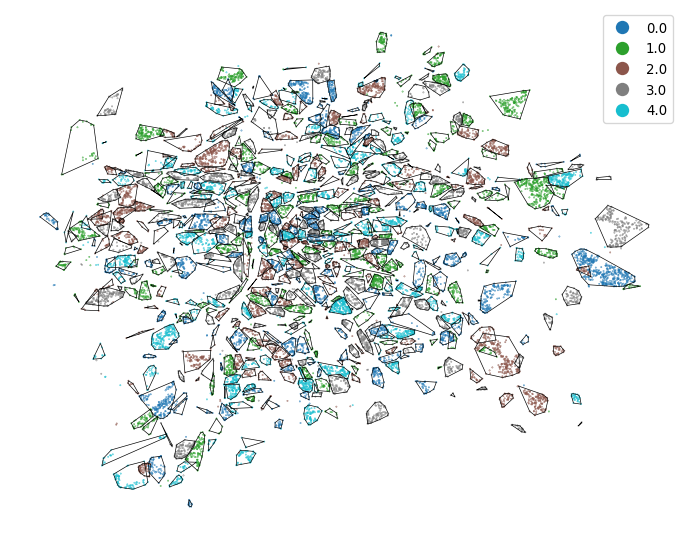

In [20]:
ax = training_sample.plot(
  "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
)
training_sample.dissolve("basic_settlement_unit").convex_hull.boundary.plot(
    ax=ax, color="k", linewidth=0.5, markersize=0
)
ax.set_axis_off()


With the new, and arguably better train-test, split, you can create new
training and evaluation data. You can use the split with the label `0`
as a test part and the rest as a train part.

In [21]:
train = training_sample["split"] != 0
X_train = independent.loc[train]
y_train = training_sample["cluster"].loc[train]

test = training_sample["split"] == 0
X_test = independent.loc[test]
y_test = training_sample["cluster"].loc[test]

New data require a new model.

In [22]:
rf_spatial_cv = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_spatial_cv.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

And its evaluation. Just use `+=` to add to the existing summary.

In [23]:
pred = rf_spatial_cv.predict(X_test)

accuracy_spatial_cv = metrics.accuracy_score(pred, y_test)
kappa_spatial_cv = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Basic model with spatial cross-validation:
  Accuracy: {round(accuracy_spatial_cv, 3)}
  Kappa:    {round(kappa_spatial_cv, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419


The results are marginally worse, but that is expected. It means that
the original model was indeed a bit leaking! The model based on spatial
CV should be more robust that the previous one, meaning that it should
perform as expected on an unseen data.

The result is worse on paper but it is now more spatially robust - it
will generalise better on unseen data.

## Feature engineering

### Map synthesis

In [24]:
distance_200 = graph.Graph.build_distance_band(training_sample, 200)
training_sample["points_in_200m"] = distance_200.cardinalities

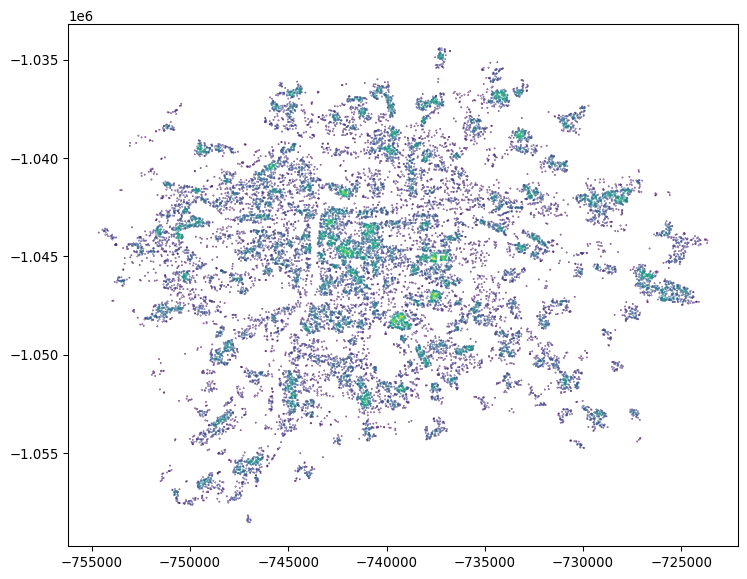

In [25]:
training_sample.plot("points_in_200m", figsize=(9, 9), markersize=0.1)
_ = ax.set_axis_off()

In [26]:
independent_proximity = training_sample[
    independent_variables + ["points_in_200m"]
]

X_train = independent_proximity.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_proximity.loc[test]
y_test = training_sample["cluster"].loc[test]

Fit a new model, with more robust split.

In [27]:
rf_proximity = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_proximity.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

Evaluate it

In [28]:
pred = rf_proximity.predict(X_test)

accuracy_proximity = metrics.accuracy_score(pred, y_test)
kappa_proximity = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Points within 200m (spatial CV):
  Accuracy: {round(accuracy_proximity, 3)}
  Kappa:    {round(kappa_proximity, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46


In [29]:
pd.Series(
    rf_proximity.feature_importances_, index=rf_proximity.feature_names_in_
).sort_values()

compactness                    0.108827
street_alignment               0.109489
points_in_200m                 0.126702
floor_area_ratio               0.146121
height                         0.159027
block_perimeter_wall_length    0.173754
interbuilding_distance         0.176080
dtype: float64

### Proximity variables

In [30]:
old_town_square = (
    gpd.tools.geocode("Old Town Square, Prague")
    .to_crs(building_data.crs)
    .geometry.item()
)

In [31]:
old_town_square = shapely.Point(-742830, -1043011)

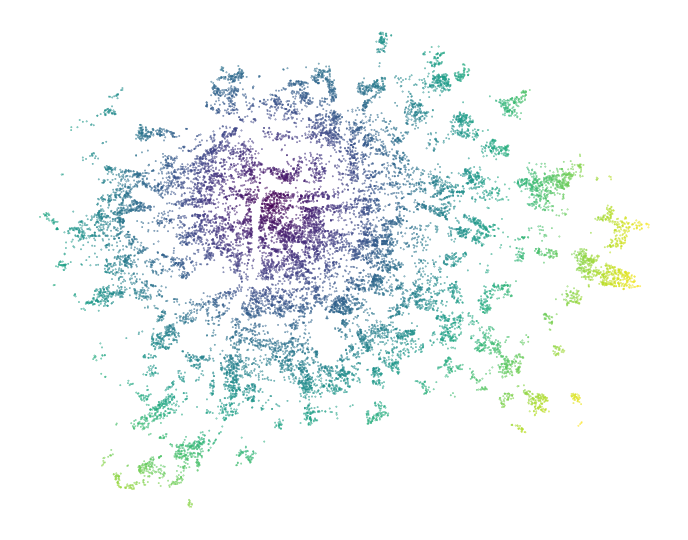

In [32]:
training_sample["distance_to_old_town"] = training_sample.distance(old_town_square)

ax = training_sample.plot("distance_to_old_town", figsize=(9, 9), markersize=0.1)
_ = ax.set_axis_off()

In [33]:
independent_distance = training_sample[
    independent_variables + ["points_in_200m", "distance_to_old_town"]
]

X_train = independent_distance.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_distance.loc[test]
y_test = training_sample["cluster"].loc[test]

Fit a new model, with more robust split.

In [34]:
rf_distance = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_distance.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

Evaluate it

In [35]:
pred = rf_distance.predict(X_test)

accuracy_distance = metrics.accuracy_score(pred, y_test)
kappa_distance = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Distance to Old Town Sq + above (spatial CV):
  Accuracy: {round(accuracy_distance, 3)}
  Kappa:    {round(kappa_distance, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532


In [36]:
pd.Series(
    rf_distance.feature_importances_, index=rf_distance.feature_names_in_
).sort_values()

compactness                    0.083833
street_alignment               0.084431
points_in_200m                 0.114884
floor_area_ratio               0.118693
height                         0.121907
block_perimeter_wall_length    0.136004
interbuilding_distance         0.143222
distance_to_old_town           0.197027
dtype: float64

### Map matching

In [37]:
price = gpd.read_file(
    "https://martinfleischmann.net/sds/chapter_03/data/SED_CenovaMapa_p_shp.zip",
    engine="pyogrio",
)
price["CENA"] = price["CENA"].replace("N", None).astype("float")
price.head(2)

In [38]:
price.crs.equals(training_sample.crs)

False

In [39]:
price = price.to_crs(training_sample.crs)

training_sample_price = training_sample.sjoin(
    price[["CENA", "geometry"]].dropna(), how="left"
).dropna(subset=["CENA"])
training_sample_price.head(2)

Another model with price included.

In [40]:
independent_proximity_price = training_sample_price[
    independent_variables + ["points_in_200m", "distance_to_old_town", "CENA"]
]

train_price = training_sample_price["split"] != 0
X_train = independent_proximity_price.loc[train_price]
y_train = training_sample_price["cluster"].loc[train_price]

test_price = training_sample_price["split"] == 0
X_test = independent_proximity_price.loc[test_price]
y_test = training_sample_price["cluster"].loc[test_price]

Fit a new model, with more robust split.

In [41]:
rf_distance_price = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_distance_price.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

Evaluate it

In [42]:
pred = rf_distance_price.predict(X_test)

accuracy_distance_price = metrics.accuracy_score(pred, y_test)
kappa_distance_price = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Price + above (spatial CV):
  Accuracy: {round(accuracy_distance_price, 3)}
  Kappa:    {round(kappa_distance_price, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.673
  Kappa:    0.553


In [43]:
pd.Series(
    rf_distance_price.feature_importances_, index=rf_distance_price.feature_names_in_
).sort_values()

compactness                    0.065115
street_alignment               0.066357
floor_area_ratio               0.086397
points_in_200m                 0.103891
height                         0.111930
interbuilding_distance         0.119208
CENA                           0.136275
block_perimeter_wall_length    0.139565
distance_to_old_town           0.171261
dtype: float64

## Spatial dependence

### Include spatially lagged variables in the model

In [44]:
distance_200_row = distance_200.transform("r")
lagged_variables = []
for var in independent_variables:
    training_sample[f"{var}_lag"] = distance_200_row.lag(training_sample[var])
    lagged_variables.append(f"{var}_lag")
training_sample.head(2)

In [45]:
independent_lag = training_sample[independent_variables + lagged_variables]

X_train = independent_lag.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_lag.loc[test]
y_test = training_sample["cluster"].loc[test]

Fit a new model, with more robust split.

In [46]:
rf_lag_200m = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_lag_200m.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

Evaluate it

In [47]:
pred = rf_lag_200m.predict(X_test)

accuracy_lag = metrics.accuracy_score(pred, y_test)
kappa_lag = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Spatial dependence - lagged model (spatial CV):
  Accuracy: {round(accuracy_lag, 3)}
  Kappa:    {round(kappa_lag, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.673
  Kappa:    0.553
Spatial dependence - lagged model (spatial CV):
  Accuracy: 0.678
  Kappa:    0.573


In [48]:
pd.Series(
    rf_lag_200m.feature_importances_, index=rf_lag_200m.feature_names_in_
).sort_values()

compactness                        0.043229
street_alignment                   0.046029
height                             0.057588
floor_area_ratio                   0.058145
block_perimeter_wall_length        0.067363
street_alignment_lag               0.070991
compactness_lag                    0.075911
height_lag                         0.102984
interbuilding_distance             0.103224
interbuilding_distance_lag         0.114796
block_perimeter_wall_length_lag    0.126160
floor_area_ratio_lag               0.133580
dtype: float64

## Spatial heterogneity

### Include x, y coordinates

In [49]:
training_sample[["x", "y"]] = training_sample.get_coordinates()
training_sample.head(2)

2 rows × 21 columns

In [50]:
independent_coordinates = training_sample[independent_variables + ["x", "y"]]

X_train = independent_coordinates.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_coordinates.loc[test]
y_test = training_sample["cluster"].loc[test]

Fit a new model, with more robust split.

In [51]:
rf_coordinates = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_coordinates.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

Evaluate it

In [52]:
pred = rf_coordinates.predict(X_test)

accuracy_coordinates = metrics.accuracy_score(pred, y_test)
kappa_coordinates = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Spatial heterogeneity - coordinates (spatial CV):
  Accuracy: {round(accuracy_coordinates, 3)}
  Kappa:    {round(kappa_coordinates, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.673
  Kappa:    0.553
Spatial dependence - lagged model (spatial CV):
  Accuracy: 0.678
  Kappa:    0.573
Spatial heterogeneity - coordinates (spatial CV):
  Accuracy: 0.632
  Kappa:    0.501


In [53]:
pd.Series(
    rf_coordinates.feature_importances_, index=rf_coordinates.feature_names_in_
).sort_values()

compactness                    0.079772
street_alignment               0.082567
height                         0.120324
floor_area_ratio               0.121949
block_perimeter_wall_length    0.140227
x                              0.141132
y                              0.144687
interbuilding_distance         0.169343
dtype: float64

> **Fixed effects**
>
> Only as an admonition pointing to the previous chapter

## Heterogeneity and dependency

In [54]:
independent_coordinates = training_sample[
    independent_variables + lagged_variables + ["x", "y"]
]

X_train = independent_coordinates.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_coordinates.loc[test]
y_test = training_sample["cluster"].loc[test]

Fit a new model, with more robust split.

In [55]:
rf_het_dep = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_het_dep.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

Evaluate it

In [56]:
pred = rf_het_dep.predict(X_test)

accuracy_het_dep = metrics.accuracy_score(pred, y_test)
kappa_het_dep = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: {round(accuracy_het_dep, 3)}
  Kappa:    {round(kappa_het_dep, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.673
  Kappa:    0.553
Spatial dependence - lagged model (spatial CV):
  Accuracy: 0.678
  Kappa:    0.573
Spatial heterogeneity - coordinates (spatial CV):
  Accuracy: 0.632
  Kappa:    0.501
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: 0.711
  Kappa:    0.615


In [57]:
pd.Series(
    rf_het_dep.feature_importances_, index=rf_het_dep.feature_names_in_
).sort_values()

compactness                        0.032525
street_alignment                   0.036007
floor_area_ratio                   0.047823
height                             0.049390
street_alignment_lag               0.057048
block_perimeter_wall_length        0.057807
compactness_lag                    0.063732
y                                  0.068235
x                                  0.071409
height_lag                         0.083217
interbuilding_distance             0.090460
interbuilding_distance_lag         0.102752
block_perimeter_wall_length_lag    0.117814
floor_area_ratio_lag               0.121782
dtype: float64

### Prediction on the whole dataset

Predict on the whole dataset

In [58]:
distance_200_all = graph.Graph.build_distance_band(building_data, 200).transform("r")
for var in independent_variables:
    building_data[f"{var}_lag"] = distance_200_all.lag(building_data[var])

building_data[["x", "y"]] = building_data.get_coordinates()

In [59]:
probabilities = rf_het_dep.predict_proba(
    building_data[independent_variables + lagged_variables + ["x", "y"]]
)
probabilities

array([[0.29, 0.05, 0.42, ..., 0.  , 0.05, 0.  ],
       [0.  , 0.04, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.  , ..., 0.49, 0.41, 0.  ],
       ...,
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.52, 0.06, 0.01, ..., 0.1 , 0.07, 0.01]])

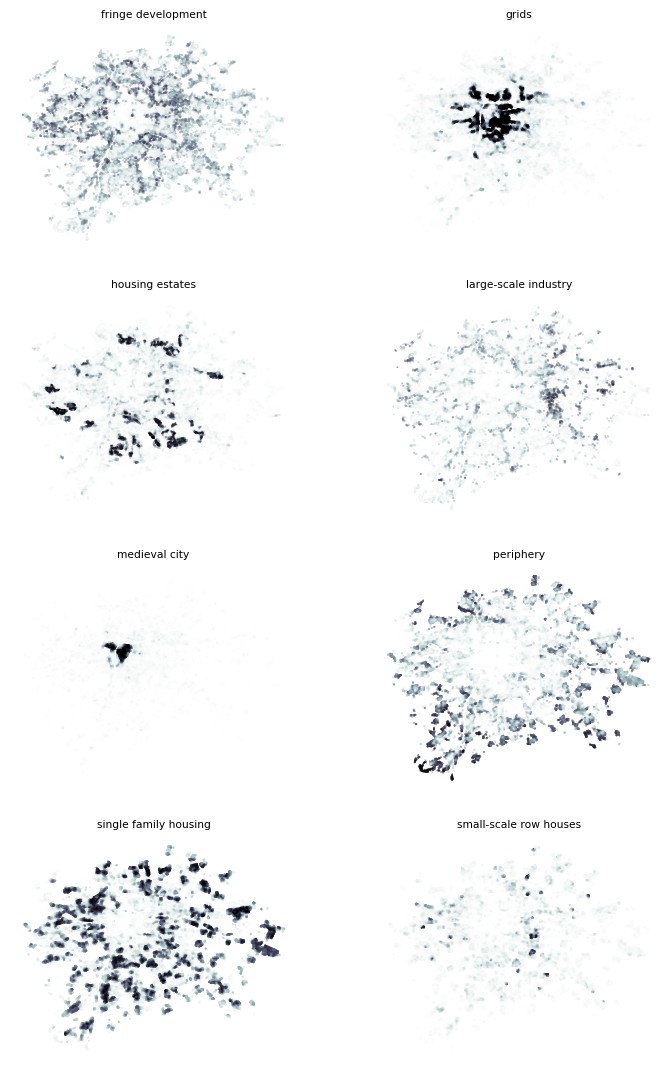

In [60]:
fig, axs = plt.subplots(4, 2, figsize=(9, 14))
axs = axs.flatten()
for i, ax in enumerate(axs):
    building_data.plot(probabilities[:, i], markersize=0.01, cmap="bone_r", ax=ax)
    axs[i].set_title(rf_het_dep.classes_[i], fontdict={"fontsize": 8})
    ax.set_axis_off()

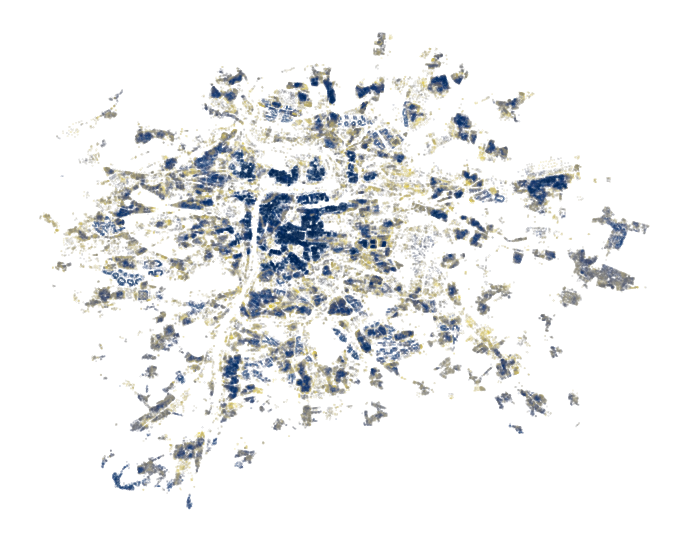

In [61]:
building_data.plot(
    probabilities.max(axis=1), markersize=0.01, cmap="cividis_r", figsize=(9, 9)
).set_axis_off()

In [62]:
predicted_class = rf_het_dep.predict(
    building_data[independent_variables + lagged_variables + ["x", "y"]]
)

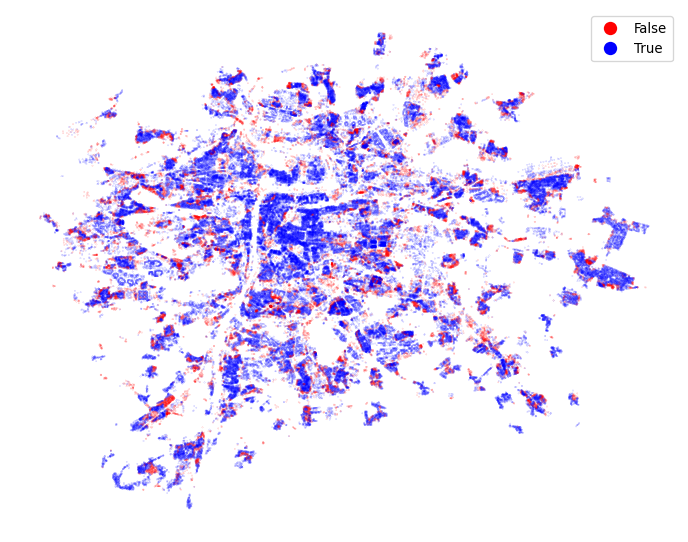

In [63]:
building_data.plot(
    predicted_class == building_data["cluster"],
    categorical=True,
    figsize=(9, 9),
    markersize=0.005,
    cmap="bwr_r",
    legend=True,
).set_axis_off()

In [64]:
pred = rf_het_dep.predict(X_test)

accuracy_all = metrics.accuracy_score(predicted_class, building_data["cluster"])
kappa_all = metrics.cohen_kappa_score(predicted_class, building_data["cluster"])

summary += f"""
Complete dataset
----------------
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: {round(accuracy_all, 3)}
  Kappa:    {round(kappa_all, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.673
  Kappa:    0.553
Spatial dependence - lagged model (spatial CV):
  Accuracy: 0.678
  Kappa:    0.573
Spatial heterogeneity - coordinates (spatial CV):
  Accuracy: 0.632
  Kappa:    0.501
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: 0.711
  Kappa:    0.615

Complete dataset
----------------
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: 0.776
  Kappa:    0.703


## Regression

In [65]:
independent = training_sample_price[independent_variables]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    independent, training_sample_price["CENA"], test_size=0.25, random_state=0
)

In [66]:
price_model = ensemble.RandomForestRegressor(random_state=0, n_jobs=-1)
price_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestRegressor RandomForestRegressor(n_jobs=-1, random_state=0)

Evaluate it

In [67]:
pred = price_model.predict(X_test)

r_squared = metrics.r2_score(pred, y_test)
mae = metrics.mean_absolute_error(pred, y_test)

summary = f"""
Evaluation metrics
==================
Basic model:
  R2:                   {round(r_squared, 3)}
  Mean absolute error:  {round(mae, 3)}
"""
print(summary)


Evaluation metrics
Basic model:
  R2:                   0.307
  Mean absolute error:  2674.415


In [68]:
predicted = model_selection.cross_val_predict(
    price_model, independent, training_sample_price["CENA"], cv=4, n_jobs=-1
)

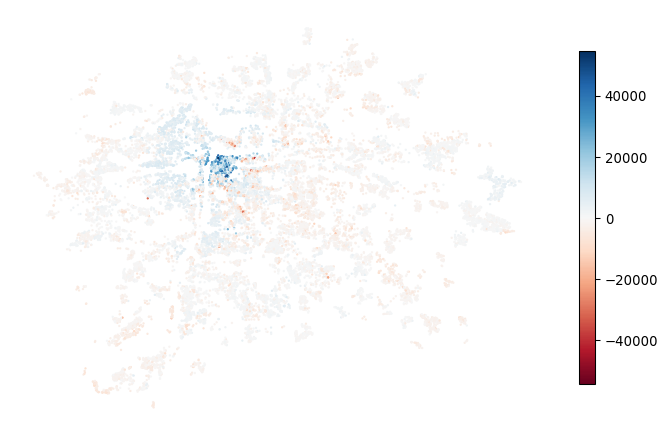

In [69]:
residuals = training_sample_price["CENA"] - predicted

maximum = np.max(np.abs(residuals))
ax = training_sample_price.plot(
    residuals,
    figsize=(9, 9),
    markersize=0.5,
    cmap="RdBu",
    legend=True,
    vmin=-maximum,
    vmax=maximum,
    legend_kwds={"shrink": 0.5},
)
_ = ax.set_axis_off()